# Modelling and Evaluation Notebook

## Objectives

- Train, evaluate, and save a Convolutional Neural Network (CNN) to classify cherry leaf images as either healthy or affected by powdery mildew. This notebook aims to satisfy the second business requirement: to enable automated detection of mildew using machine learning.


## Inputs

- Cleaned image dataset (`inputs/cherry_leaves/cherry-leaves`)
- Preprocessed train, validation, and test directories
- Image dimensions confirmed to be 256x256 px

## Outputs

- A trained CNN model saved as `.h5` for use in the dashboard
- Training and validation accuracy/loss curves
- Evaluation metrics on the test set (accuracy, confusion matrix, classification report)
- Visualisation of model performance
- Conclusions and next steps

## Additional Comments

- This notebook builds on the findings of the data collection and visualisation notebooks. It uses augmented image data to improve generalisation and incorporates early stopping to prevent overfitting. The final model is intended to be lightweight enough for use in a real-time prediction dashboard.



---

## Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set working directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-mildew-detection-in-cherry-leaves/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-mildew-detection-in-cherry-leaves'

## Set input directories
- Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
work_dir = os.getcwd()
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available. Create a new version.')
    pass
else:
    os.makedirs(file_path)

Old version is already available. Create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




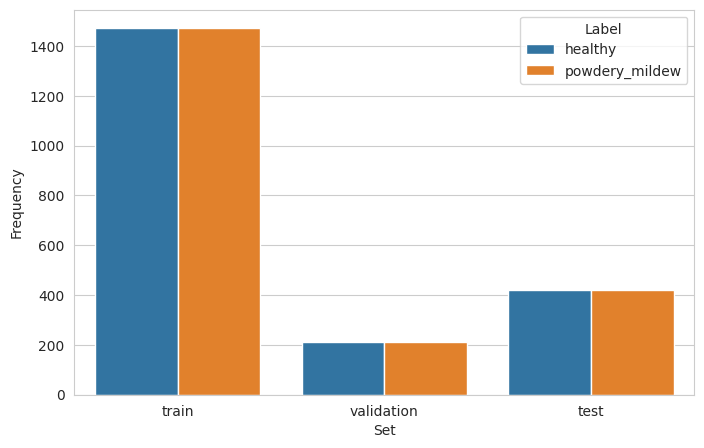

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

## ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-09 20:57:19.618747: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 20:57:19.649234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### - Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### - Augment training image dataset

In [12]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### - Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### - Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### - Plot augmented training image

(20, 256, 256, 3)


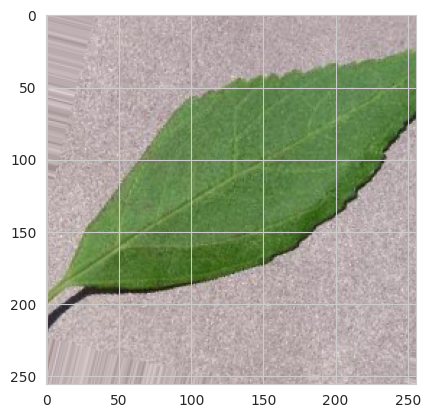

(20, 256, 256, 3)


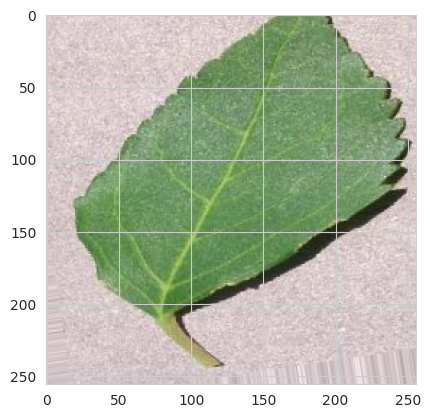

(20, 256, 256, 3)


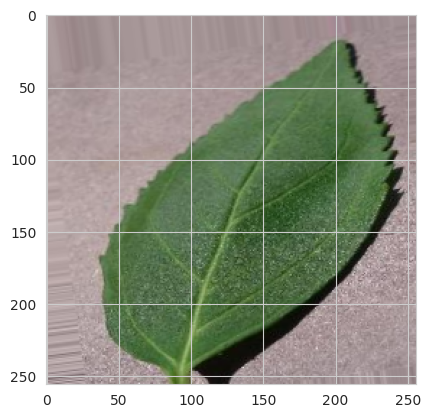

In [15]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### - Plot augmented validation and test images

(20, 256, 256, 3)


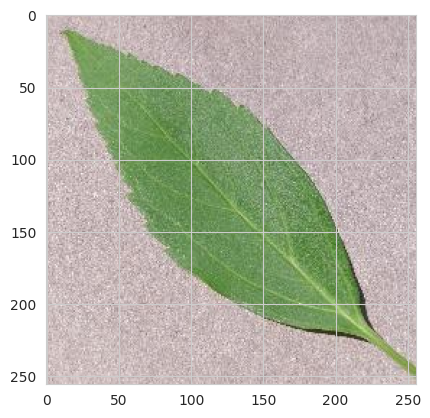

(20, 256, 256, 3)


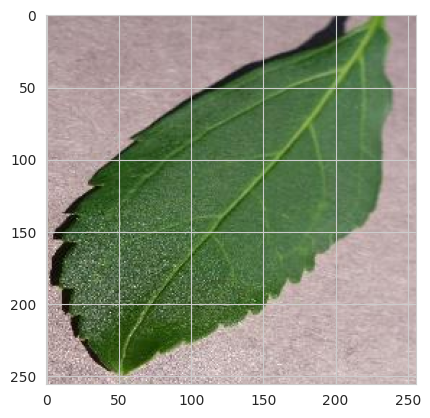

(20, 256, 256, 3)


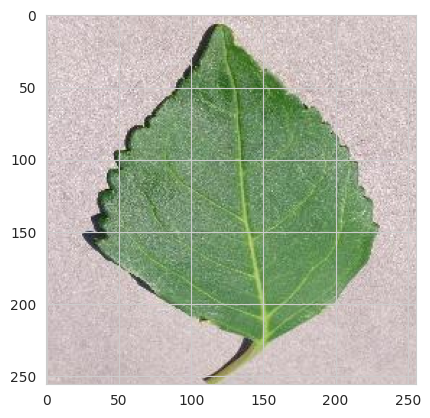

In [16]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


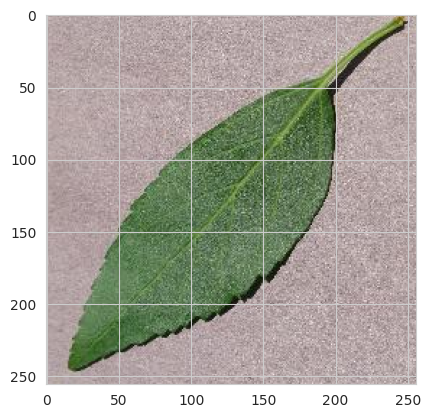

(20, 256, 256, 3)


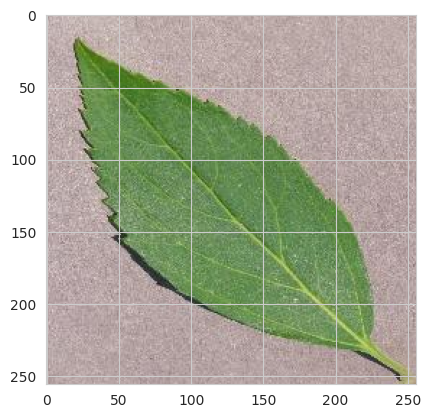

(20, 256, 256, 3)


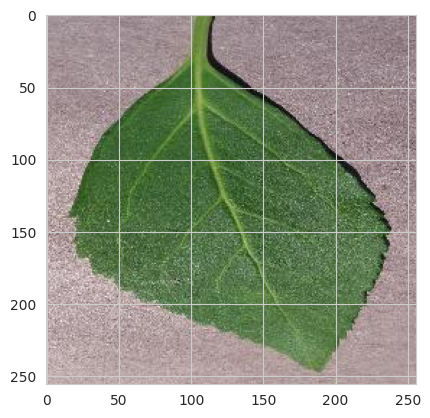

In [17]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

### - Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### - Model

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### - Model Summary

In [21]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

### - Early Stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [23]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 121s 809ms/step - accuracy: 0.7173 - loss: 0.5764 - val_accuracy: 0.9143 - val_loss: 0.2566
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:34 651ms/step - accuracy: 0.9500 - loss: 0.1265

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9500 - loss: 0.1265 - val_accuracy: 0.9667 - val_loss: 0.1490
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 801ms/step - accuracy: 0.9718 - loss: 0.1022 - val_accuracy: 0.9905 - val_loss: 0.0333
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 0.0355 - val_accuracy: 0.9929 - val_loss: 0.0299
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 790ms/step - accuracy: 0.9767 - loss: 0.0584 - val_accuracy: 0.9881 - val_loss: 0.0676
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9881 - val_loss: 0.0609
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 139s 801ms/step - accuracy: 0.9899 - loss: 0.0370 - val_accuracy: 0.9881 - val_loss: 0.0503


## Save model

In [24]:
model.save('outputs/v1/mildew_detector_model.h5')

---

# Model Performance

---

## Model learning curve

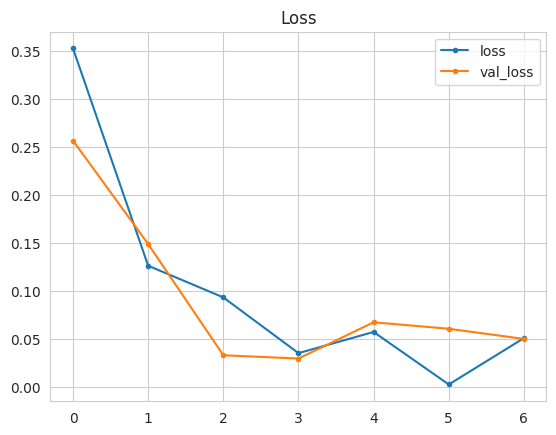

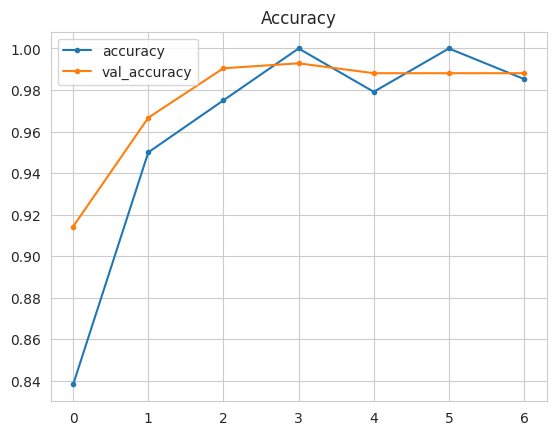

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [26]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

Evaluate model on test set

In [27]:
evaluation = model.evaluate(test_set)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9963 - loss: 0.0129


### Save evaluation pickle

In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data
- Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


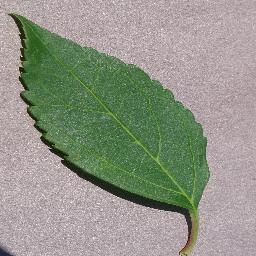

In [29]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

- Convert image to array and prepare for prediction

In [30]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


- Predict class probabilities

In [31]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
0.9999847594626772
healthy


### Conclusions and Next Steps

This final section evaluates the model using unseen test data.  
The test loss and accuracy are saved to a JSON file, which is used by the dashboard to display generalised model performance.

**Next Steps:**
- Validate these metrics in the deployed Streamlit app
- Optionally, improve the model through hyperparameter tuning or additional data

## Evaluate the model on the test set

In [32]:
test_eval = model.evaluate(test_set, verbose=1)
results = {"loss": test_eval[0], "accuracy": test_eval[1]}

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9963 - loss: 0.0129


### Save test evaluation results to a JSON file

In [33]:
import json
with open(f"outputs/{version}/test_evaluation.json", "w") as f:
    json.dump(results, f)

---

# Push files to Repo

- .gitignore

In [34]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

- Git status

In [35]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 10 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/mildew_detector_model.h5
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/test_evaluation.json
	src/machine_learning/__init__.py
	src/machine_learning/evaluate_clf.py

no changes added to commit (use "git add" and/or "git commit -a")


- Git add

In [36]:
!git add .

- Git commit

In [37]:
!git commit -am " Add new plots"

fatal: Unable to create '/workspaces/milestone-project-mildew-detection-in-cherry-leaves/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.


- Git Push

In [38]:
!git push

Enumerating objects: 54, done.
Counting objects: 100% (54/54), done.
Delta compression using up to 2 threads
Compressing objects: 100% (47/47), done.
Writing objects: 100% (51/51), 10.65 KiB | 1.78 MiB/s, done.
Total 51 (delta 23), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (23/23), completed with 3 local objects.
To https://github.com/JLG-96/milestone-project-mildew-detection-in-cherry-leaves
   3950bfe..4e3eac6  main -> main
